# Load returns to AWS SQL db

In [30]:
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Load environment variables from the .secrets file
load_dotenv(".secrets")

True

In [31]:
add_new_data = False

## Initialize SQL connection

In [32]:
# Database connection parameters from environment variables
DB_NAME = os.getenv("AWS_RDS_DBNAME")
USER = os.getenv("AWS_RDS_USERNAME")
PASSWORD = os.getenv("AWS_RDS_PASSWORD")
HOST = os.getenv("AWS_RDS_HOST")
PORT = os.getenv("AWS_RDS_PORT")

# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
cur = conn.cursor()
conn

<connection object at 0x0000028D86CE3670; dsn: 'user=lbassetti password=xxx dbname=postgres host=sa-met-1.cna4g6g06njt.eu-central-2.rds.amazonaws.com port=5432', closed: 0>

## Load CSV and write to tables

In [33]:
# Directory containing the files
directory_path = 'data/returns'

# Column mapping for renaming
column_mapping = {
    'Vintage Year': 'Vintage_Year',
    'Asset Class Group': 'Asset_Class',
    'First Transaction Period': 'First_Transaction_Period',
    'As of Date': 'As_of_Date',
    'Fund Count': 'Fund_Count',
    'Pooled Return (LP) (%)': 'IRR_Pooled',
    'Equal Weighted (LP) (%)': 'IRR_Equal_Weighted',
    'Capital Weighted (LP) (%)': 'IRR_Capital_Weighted',
    'Average (LP) (%)': 'IRR_Average',
    'Top 5% (LP) (%)': 'IRR_Top_5',
    'Upper Quartile (LP) (%)': 'IRR_Upper_Quartile',
    'Median (LP) (%)': 'IRR_Median',
    'Lower Quartile (LP) (%)': 'IRR_Lower_Quartile',
    'Bottom 5% (LP) (%)': 'IRR_Bottom_5',
    'Standard Deviation (LP) (%)': 'IRR_Std_Dev',
    'Pooled Return (LP)': 'TVPI_Pooled',
    'Capital Weighted (LP)': 'TVPI_Capital_Weighted',
    'Average (LP)': 'TVPI_Average',
    'Top 5% (LP)': 'TVPI_Top_5',
    'Upper Quartile (LP)': 'TVPI_Upper_Quartile',
    'Median (LP)': 'TVPI_Median',
    'Lower Quartile (LP)': 'TVPI_Lower_Quartile',
    'Bottom 5% (LP)': 'TVPI_Bottom_5',
    'Standard Deviation (LP)': 'TVPI_Std_Dev',
    'Pooled Return (LP).1': 'DPI_Pooled',
    'Capital Weighted (LP).1': 'DPI_Capital_Weighted',
    'Average (LP).1': 'DPI_Average',
    'Top 5% (LP).1': 'DPI_Top_5',
    'Upper Quartile (LP).1': 'DPI_Upper_Quartile',
    'Median (LP).1': 'DPI_Median',
    'Lower Quartile (LP).1': 'DPI_Lower_Quartile',
    'Bottom 5% (LP).1': 'DPI_Bottom_5',
    'Standard Deviation (LP).1': 'DPI_Std_Dev'
}

def process_and_upload_file(file_path, geo_region):
    # Read the Excel file
    data = pd.read_excel(file_path, sheet_name='Returns Report', header=4)
    data = data.assign(Geo_Region=geo_region)

    # Remove rows where 'Asset_Class' is 'Sub-Total'
    data = data[data['Asset Class Group'] != 'Sub-Total']

    # Convert columns to numeric, handling errors
    columns_to_convert = data.columns[5:33]
    data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Rename columns
    data.rename(columns=column_mapping, inplace=True)

    # Drop rows with missing values
    data.dropna(inplace=True)

    # Connect to the PostgreSQL database
    conn = psycopg2.connect(
        dbname=DB_NAME,
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT
    )
    cur = conn.cursor()

    # Upload data to PostgreSQL
    for _, row in data.iterrows():
        insert_query = '''
        INSERT INTO public.pe_returns (Vintage_Year, Asset_Class, First_Transaction_Period, As_of_Date, Fund_Count,
            IRR_Pooled, IRR_Equal_Weighted, IRR_Capital_Weighted, IRR_Average, IRR_Top_5, IRR_Upper_Quartile,
            IRR_Median, IRR_Lower_Quartile, IRR_Bottom_5, IRR_Std_Dev, TVPI_Pooled, TVPI_Capital_Weighted,
            TVPI_Average, TVPI_Top_5, TVPI_Upper_Quartile, TVPI_Median, TVPI_Lower_Quartile, TVPI_Bottom_5,
            TVPI_Std_Dev, DPI_Pooled, DPI_Capital_Weighted, DPI_Average, DPI_Top_5, DPI_Upper_Quartile, DPI_Median,
            DPI_Lower_Quartile, DPI_Bottom_5, DPI_Std_Dev, Geo_Region)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT ON CONSTRAINT unique_entry_constraint DO NOTHING;
        '''
        cur.execute(insert_query, tuple(row))

    # Commit transaction
    conn.commit()

    # Close cursor and connection
    cur.close()
    conn.close()
    print(f"Data from {file_path} uploaded successfully.")

if add_new_data:
    # Main routine to process all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".xlsx"):
            geo_region = filename.split('_')[-1].replace('.xlsx', '')  # Determine region based on filename
            file_path = os.path.join(directory_path, filename)
            process_and_upload_file(file_path, geo_region)
else:
    print(f'Load data SKIPPED: add_new_data == False')


Load data SKIPPED: add_new_data == False


## Read PE_Returns data

In [34]:
# Connect to PostgreSQL and read the table into a DataFrame
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Query the data
query = "SELECT * FROM public.pe_returns;"
data = pd.read_sql(query, conn)

# Close the connection
conn.close()
data.sort_values(by=['vintage_year','asset_class'], inplace=True)
data

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_12260\2105778500.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


,vintage_year,asset_class,first_transaction_period,as_of_date,fund_count,irr_pooled,irr_equal_weighted,irr_capital_weighted,irr_average,irr_top_5,...,dpi_pooled,dpi_capital_weighted,dpi_average,dpi_top_5,dpi_upper_quartile,dpi_median,dpi_lower_quartile,dpi_bottom_5,dpi_std_dev,geo_region
142,1981,Venture Capital,1981 Q1,2024-03-31,9.0,0.083918,0.090563,0.084453,0.088877,0.165347,...,1.712785,1.712785,1.809437,2.692965,2.019627,1.900708,1.312518,1.130821,0.592168,US
143,1982,Venture Capital,1982 Q1,2024-03-31,11.0,0.076523,0.077253,0.078809,0.077249,0.115128,...,1.824364,1.824364,1.993471,3.098608,2.203698,1.749979,1.618938,1.417209,0.623608,US
144,1983,Venture Capital,1983 Q1,2024-03-31,28.0,0.100168,0.096946,0.094323,0.091115,0.150955,...,1.979810,1.978977,1.930192,3.011332,2.177856,1.845907,1.488012,1.014406,0.712307,US
145,1984,Venture Capital,1984 Q1,2024-03-31,33.0,0.087838,0.083348,0.082579,0.079413,0.204632,...,1.785304,1.785304,1.730571,2.873935,2.047345,1.712859,1.273571,0.536430,0.736387,US
146,1985,Venture Capital,1985 Q1,2024-03-31,25.0,0.130625,0.131237,0.126037,0.119836,0.246480,...,2.718912,2.718925,2.672084,5.766211,3.074660,2.394209,1.666764,1.003903,1.502653,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,2023,Buyout & Growth Equity,2023 Q1,2024-03-31,41.0,0.145259,-0.016260,0.124777,-0.027422,1.016730,...,0.012678,0.012375,0.020406,0.058155,0.000000,0.000000,0.000000,0.000000,0.079192,US
331,2023,Fund of Funds & Secondary Funds,2023 Q1,2024-03-31,11.0,0.675979,0.496926,0.613859,0.555816,1.937118,...,0.015945,0.013054,0.001637,0.009003,0.000000,0.000000,0.000000,0.000000,0.005429,US
330,2023,Real Estate,2023 Q1,2024-03-31,11.0,-0.148758,0.034740,-0.193510,-0.125276,0.380523,...,0.005047,0.010614,0.011331,0.062319,0.000000,0.000000,0.000000,0.000000,0.029831,US
329,2023,Subordinated Capital & Distressed,2023 Q1,2024-03-31,11.0,0.239877,0.253213,1.601510,0.129261,7.496766,...,0.018359,0.019396,0.021911,0.073954,0.036922,0.005760,0.000000,0.000000,0.032536,US


In [35]:
# Define robust statistics function
def robust_statistics(data, groupby_columns, metric_columns):
    stats = data.groupby(groupby_columns)[metric_columns].agg(
        count=('fund_count', 'count'),
        fund_count_mean=('fund_count', 'mean'),
        fund_count_median=('fund_count', 'median'),
        fund_count_std_dev=('fund_count', 'std'),
        fund_count_min=('fund_count', 'min'),
        fund_count_max=('fund_count', 'max'),
        irr_mean=('irr_average', 'mean'),
        irr_median=('irr_average', 'median'),
        irr_min=('irr_average', 'min'),
        irr_max=('irr_average', 'max'),
        tvpi_mean=('tvpi_average', 'mean'),
        tvpi_median=('tvpi_average', 'median'),
        tvpi_min=('tvpi_average', 'min'),
        tvpi_max=('tvpi_average', 'max'),
        dpi_mean=('dpi_average', 'mean'),
        dpi_median=('dpi_average', 'median'),
        dpi_min=('dpi_average', 'min'),
        dpi_max=('dpi_average', 'max'),
    )
    return stats

# Define the columns to calculate robust statistics for
metric_columns = ['fund_count', 'irr_average', 'tvpi_average', 'dpi_average']

# Generate robust statistics
robust_stats = robust_statistics(data, groupby_columns=['geo_region', 'asset_class'], metric_columns=metric_columns)

# Print the results in a tabular form
print("Robust Statistics for Fund Count, IRR, TVPI, and DPI by Geo Region and Asset Class:")
robust_stats



Robust Statistics for Fund Count, IRR, TVPI, and DPI by Geo Region and Asset Class:


count  fund_count_mean  \
geo_region asset_class                                                 
APAC       Buyout & Growth Equity                23        16.521739   
           Fund of Funds & Secondary Funds        1        12.000000   
           Real Estate                            4        13.250000   
           Subordinated Capital & Distressed      1         9.000000   
           Venture Capital                       15        16.000000   
EU         Buyout & Growth Equity                30        18.966667   
           Fund of Funds & Secondary Funds        3        11.000000   
           Real Estate                           12        13.083333   
           Subordinated Capital & Distressed      7         9.285714   
           Venture Capital                       14        11.928571   
ROW        Buyout & Growth Equity                13        11.384615   
           Fund of Funds & Secondary Funds        4         9.750000   
           Natural Resources                      2         8.000000   
           Subordinated Capital & Distressed      2         8.000000   
           Venture Capital                       11         9.272727   
US         Buyout & Growth Equity                35        44.571429   
           Fund of Funds & Secondary Funds       28        28.214286   
           Infrastructure                         4        10.500000   
           Natural Resources                     22        14.500000   
           Real Estate                           30        32.100000   
           Subordinated Capital & Distressed     28        20.214286   
           Venture Capital                       43        58.046512   

                                              fund_count_median  \
geo_region asset_class                                            
APAC       Buyout & Growth Equity                          16.0   
           Fund of Funds & Secondary Funds                 12.0   
           Real Estate                                     12.0   
           Subordinated Capital & Distressed                9.0   
           Venture Capital                                 15.0   
EU         Buyout & Growth Equity                          18.5   
           Fund of Funds & Secondary Funds                 12.0   
           Real Estate                                     13.0   
           Subordinated Capital & Distressed                9.0   
           Venture Capital                                 11.5   
ROW        Buyout & Growth Equity                          10.0   
           Fund of Funds & Secondary Funds                  9.5   
           Natural Resources                                8.0   
           Subordinated Capital & Distressed                8.0   
           Venture Capital                                  9.0   
US         Buyout & Growth Equity                          42.0   
           Fund of Funds & Secondary Funds                 26.5   
           Infrastructure                                  10.0   
           Natural Resources                               13.5   
           Real Estate                                     31.5   
           Subordinated Capital & Distressed               21.0   
           Venture Capital                                 54.0   

                                              fund_count_std_dev  \
geo_region asset_class                                             
APAC       Buyout & Growth Equity                       6.992656   
           Fund of Funds & Secondary Funds                   NaN   
           Real Estate                                  3.947573   
           Subordinated Capital & Distressed                 NaN   
           Venture Capital                              5.855400   
EU         Buyout & Growth Equity                       6.211687   
           Fund of Funds & Secondary Funds              2.645751   
           Real Estate                                  3.423404   
           Subordinated Capi

## Run EDA

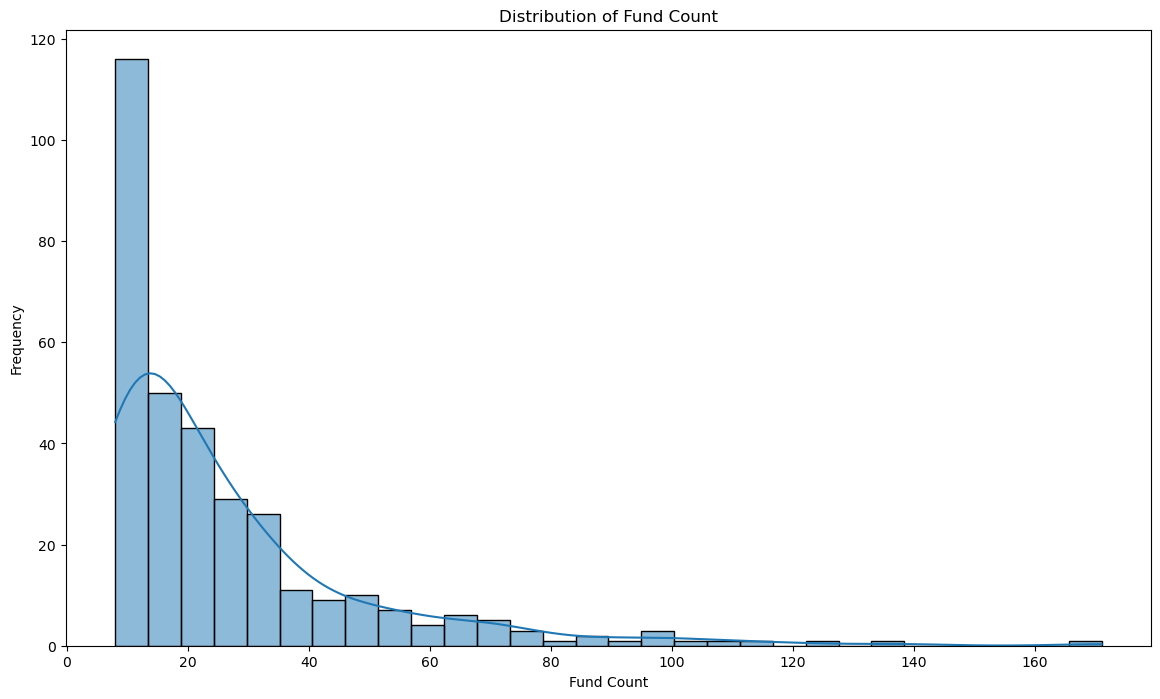

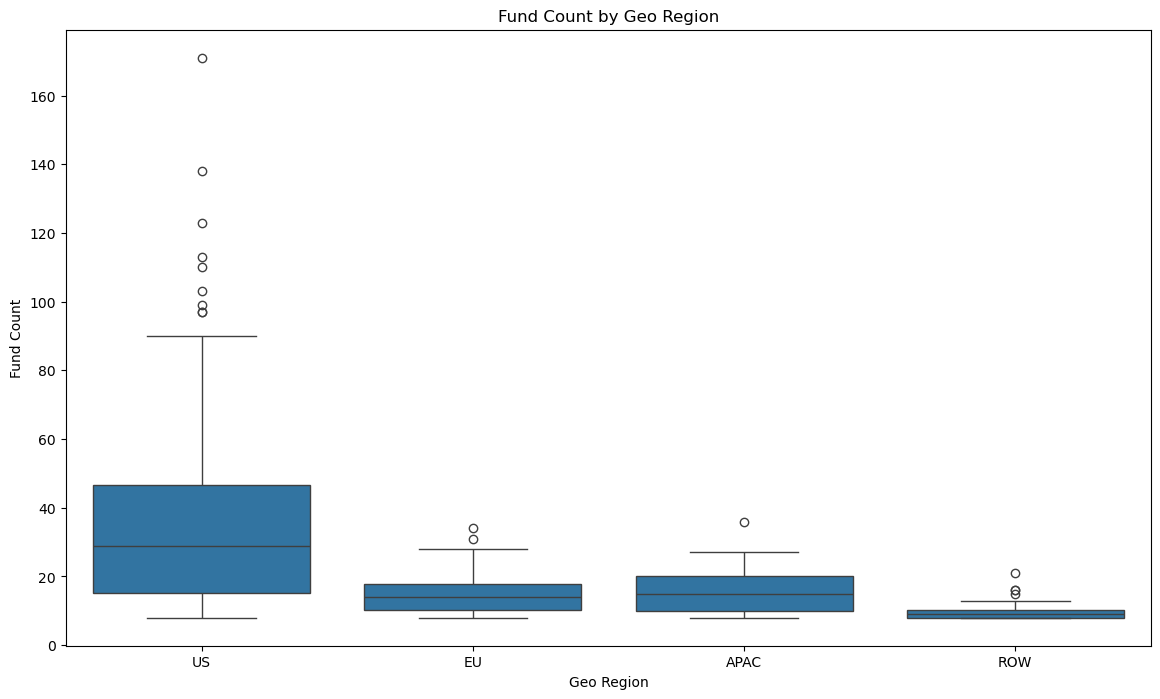

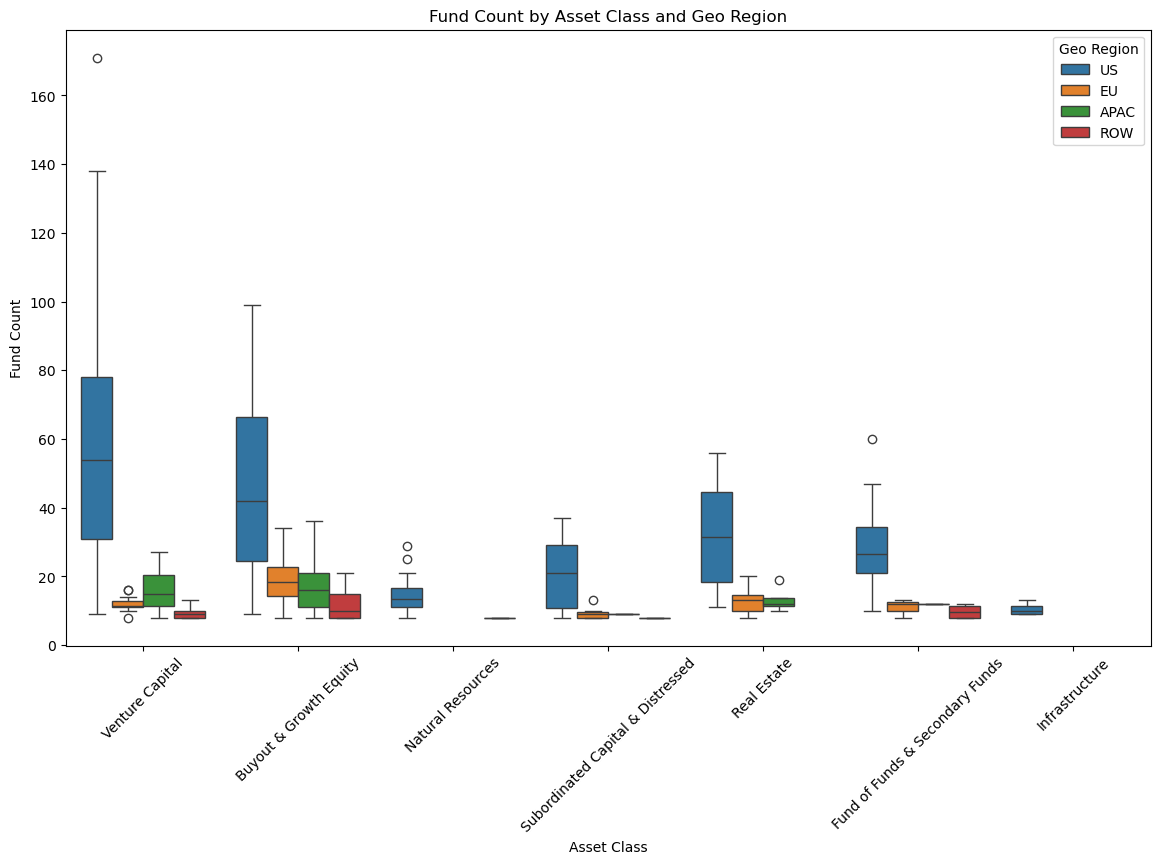

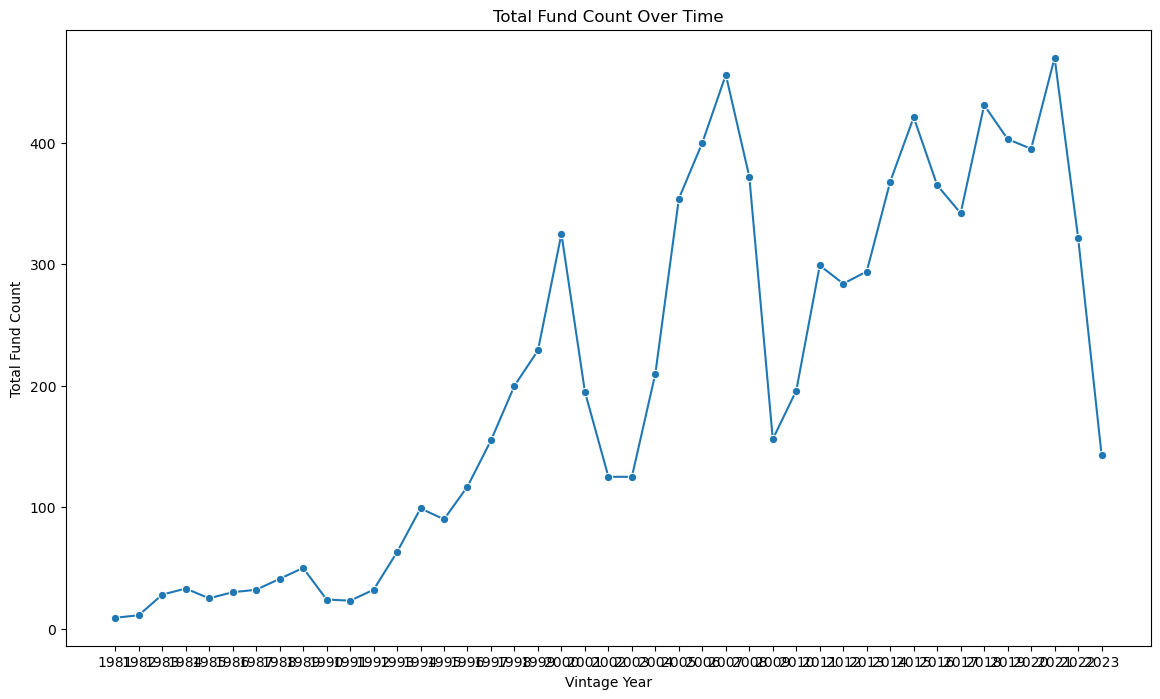

In [36]:
# 1. Histogram and KDE plot of Fund Count
plt.figure(figsize=(14, 8))
sns.histplot(data['fund_count'].dropna(), bins=30, kde=True)
plt.title('Distribution of Fund Count')
plt.xlabel('Fund Count')
plt.ylabel('Frequency')
plt.show()

# 2. Boxplot of Fund Count by Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='geo_region', y='fund_count')
plt.title('Fund Count by Geo Region')
plt.xlabel('Geo Region')
plt.ylabel('Fund Count')
plt.show()

# 3. Boxplot of Fund Count by Asset Class
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='fund_count', hue='geo_region')
plt.title('Fund Count by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Fund Count')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()

# 4. Time Series of Total Fund Count by Vintage Year
plt.figure(figsize=(14, 8))
fund_count_by_year = data.groupby('vintage_year')['fund_count'].sum().reset_index()
sns.lineplot(data=fund_count_by_year, x='vintage_year', y='fund_count', marker="o")
plt.title('Total Fund Count Over Time')
plt.xlabel('Vintage Year')
plt.ylabel('Total Fund Count')
plt.show()


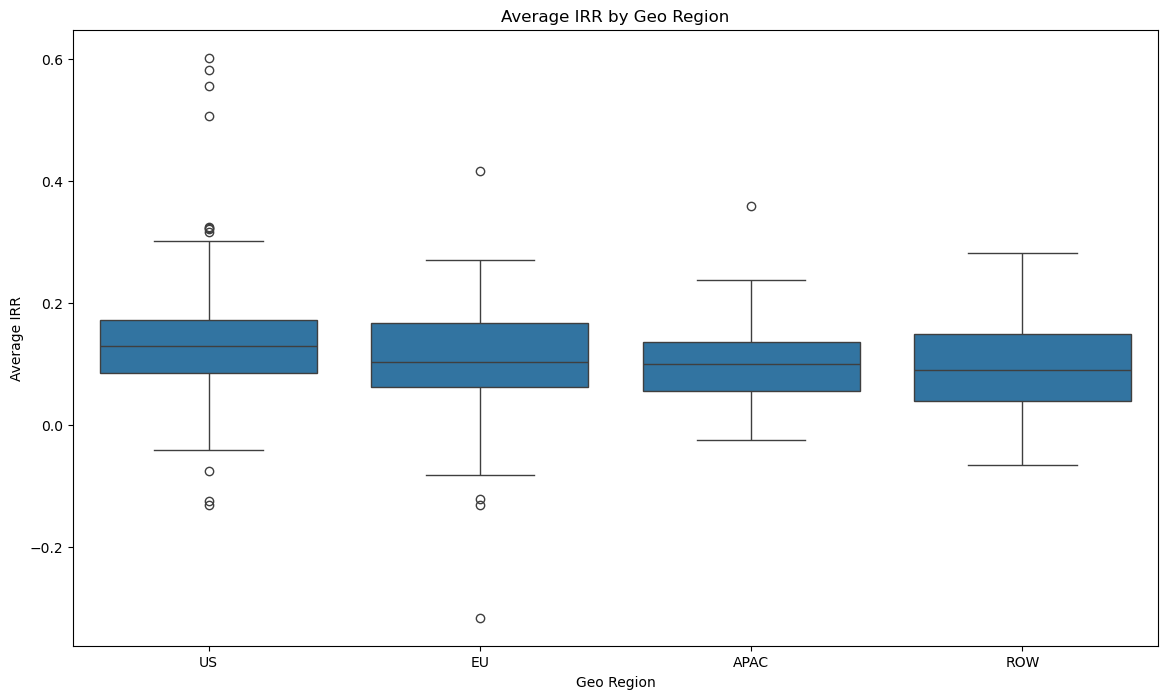

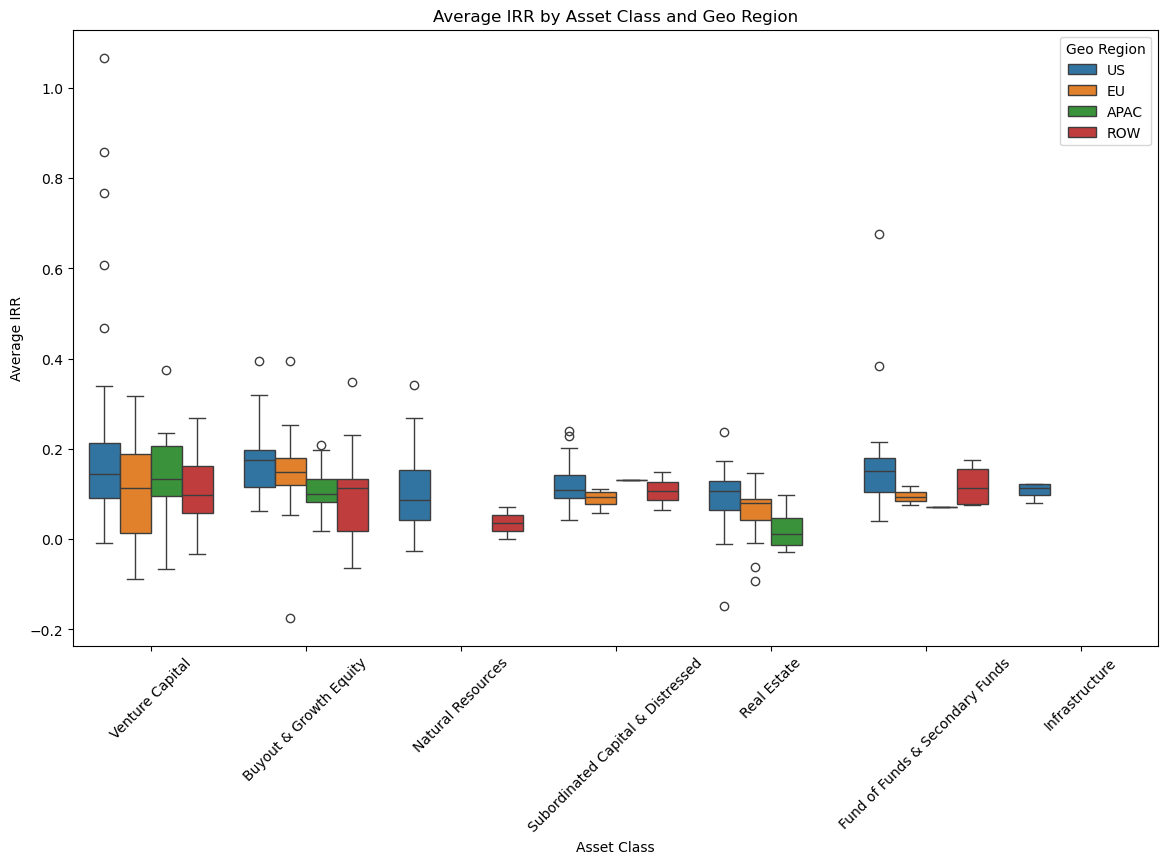

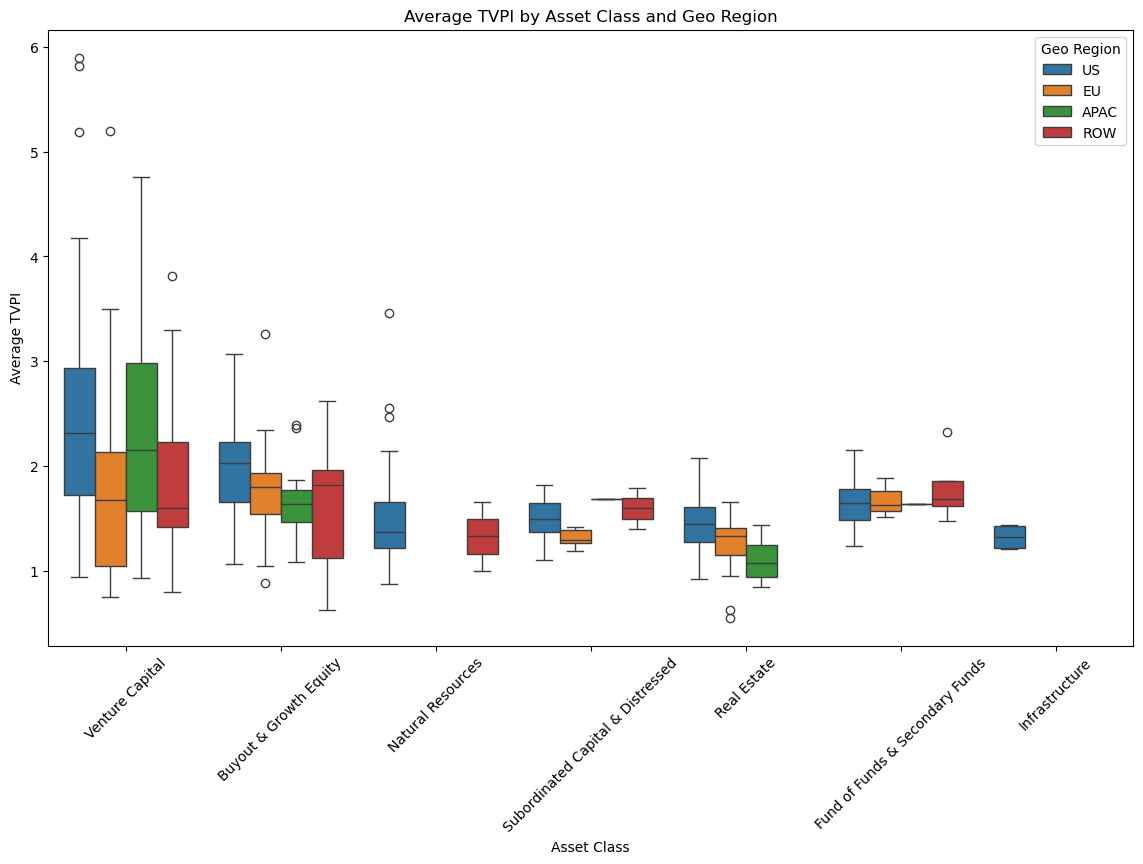

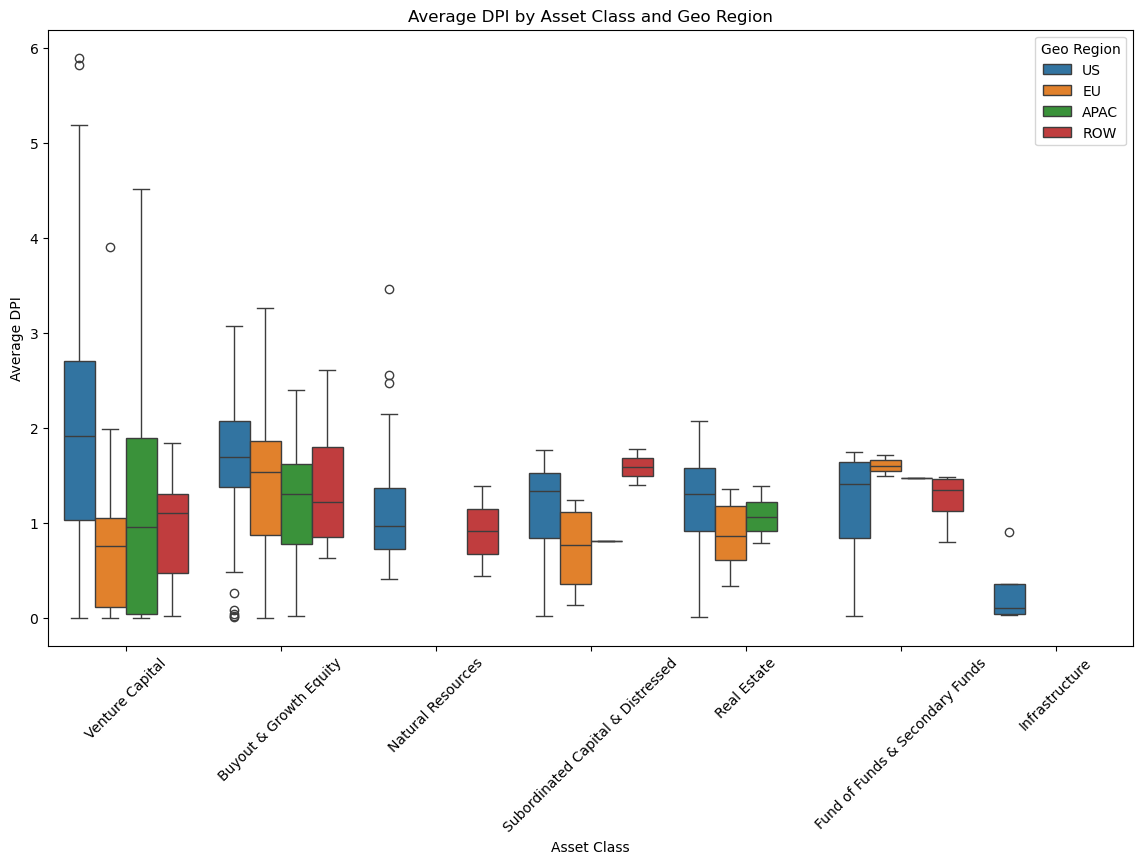

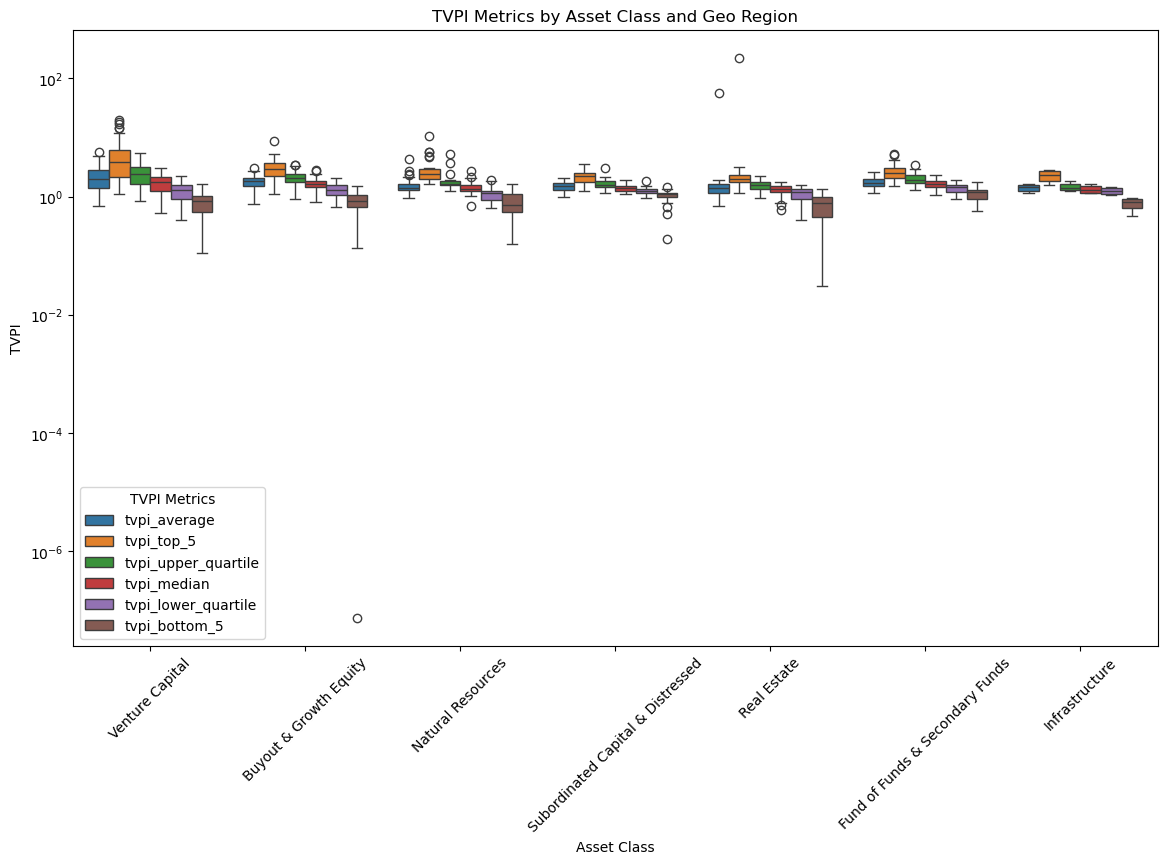

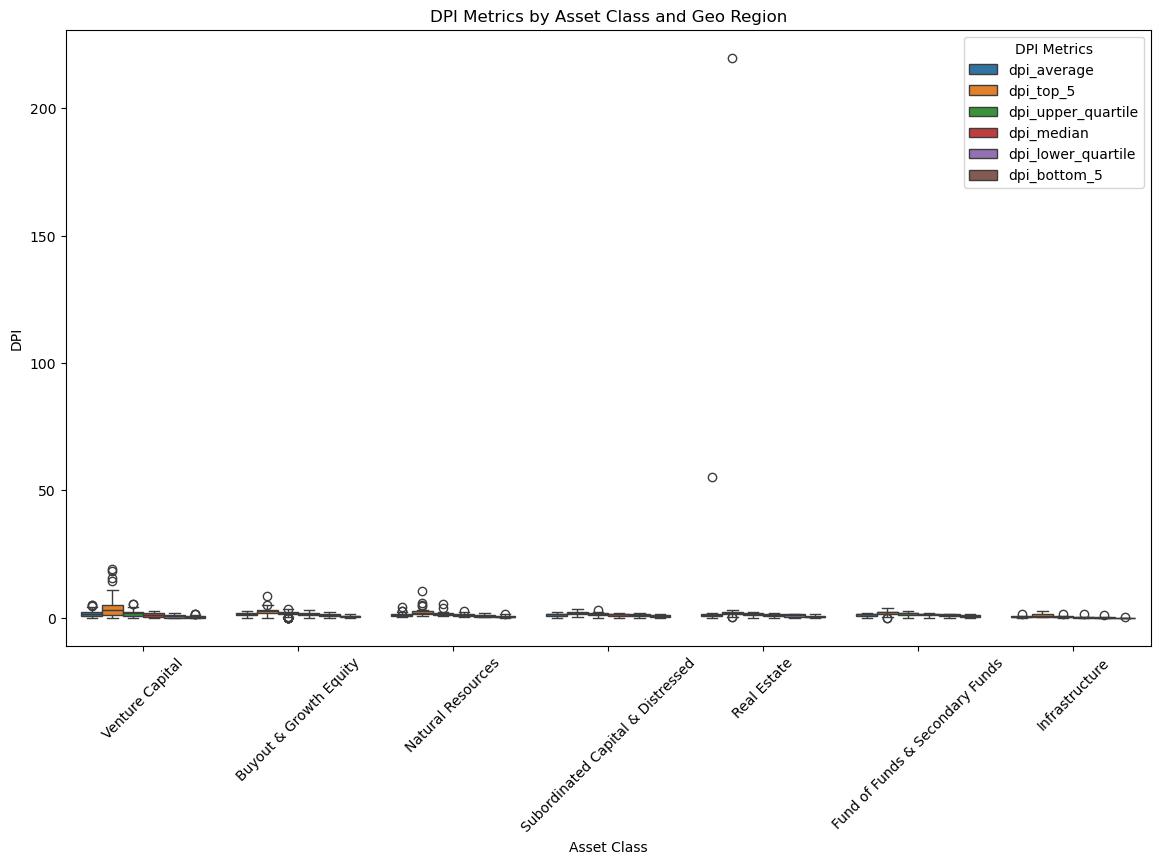

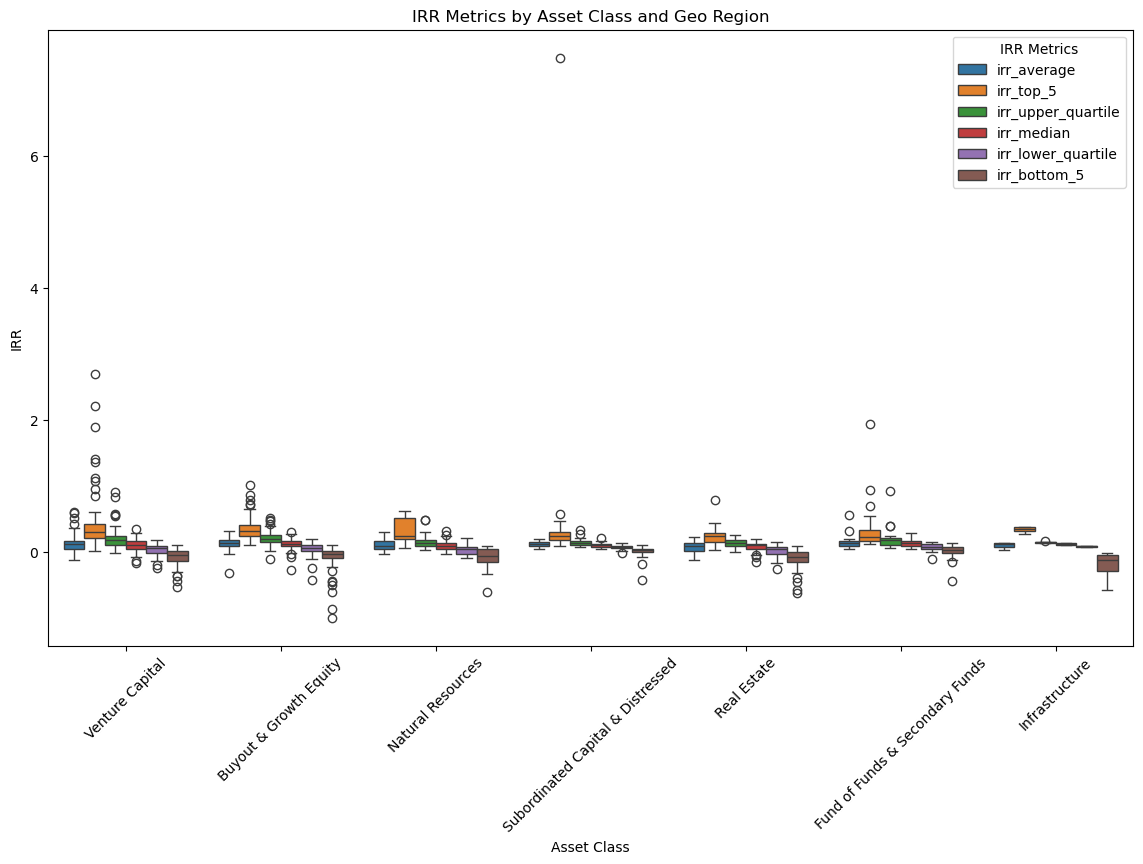

In [37]:
# Average IRR by geo_region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='geo_region', y='irr_average')
plt.title('Average IRR by Geo Region')
plt.xlabel('Geo Region')
plt.ylabel('Average IRR')
plt.show()

# # Time Series of TVPI by vintage_year and asset_class
# plt.figure(figsize=(14, 8))
# sns.lineplot(data=data, x='vintage_year', y='irr_pooled', hue='geo_region', style='asset_class', marker="o")
# plt.title('Pooled IRR Over Time by Geo Region and Asset Class')
# plt.xlabel('Vintage Year')
# plt.ylabel('irr_pooled Pooled')
# plt.legend(title='Geo Region & Asset Class')
# plt.show()

# # Time Series of TVPI by vintage_year and asset_class
# plt.figure(figsize=(14, 8))
# sns.lineplot(data=data, x='vintage_year', y='tvpi_pooled', hue='geo_region', style='asset_class', marker="o")
# plt.title('Pooled TVPI Over Time by Geo Region and Asset Class')
# plt.xlabel('Vintage Year')
# plt.ylabel('TVPI Pooled')
# plt.legend(title='Geo Region & Asset Class')
# plt.show()

# # Time Series of TVPI by vintage_year and asset_class
# plt.figure(figsize=(14, 8))
# sns.lineplot(data=data, x='vintage_year', y='dpi_pooled', hue='geo_region', style='asset_class', marker="o")
# plt.title('Pooled DPI Over Time by Geo Region and Asset Class')
# plt.xlabel('Vintage Year')
# plt.ylabel('dpi_pooled')
# plt.legend(title='Geo Region & Asset Class')
# plt.show()


# Plotting dispersion of geo_region for each asset_class in terms of avg TVPI, DPI, and IRR


# 3. Average IRR by Asset Class and Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='irr_pooled', hue='geo_region')
plt.title('Average IRR by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Average IRR')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()

# 1. Average TVPI by Asset Class and Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='tvpi_pooled', hue='geo_region')
plt.title('Average TVPI by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Average TVPI')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()

# 2. Average DPI by Asset Class and Geo Region
plt.figure(figsize=(14, 8))
sns.boxplot(data=data, x='asset_class', y='dpi_pooled', hue='geo_region')
plt.title('Average DPI by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('Average DPI')
plt.legend(title='Geo Region')
plt.xticks(rotation=45)
plt.show()


# Boxplot of TVPI by Asset Class and Geo Region (with multiple metrics)
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(data, id_vars=['asset_class', 'geo_region'], 
                         value_vars=['tvpi_average', 'tvpi_top_5', 'tvpi_upper_quartile', 'tvpi_median', 
                                     'tvpi_lower_quartile', 'tvpi_bottom_5']),
            x='asset_class', y='value', hue='variable')
plt.title('TVPI Metrics by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('TVPI')
plt.legend(title='TVPI Metrics')
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

# Boxplot of DPI by Asset Class and Geo Region (with multiple metrics)
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(data, id_vars=['asset_class', 'geo_region'], 
                         value_vars=['dpi_average', 'dpi_top_5', 'dpi_upper_quartile', 'dpi_median', 
                                     'dpi_lower_quartile', 'dpi_bottom_5']),
            x='asset_class', y='value', hue='variable')
plt.title('DPI Metrics by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('DPI')
plt.legend(title='DPI Metrics')
# plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

# Boxplot of IRR by Asset Class and Geo Region (with multiple metrics)
plt.figure(figsize=(14, 8))
sns.boxplot(data=pd.melt(data, id_vars=['asset_class', 'geo_region'], 
                         value_vars=['irr_average', 'irr_top_5', 'irr_upper_quartile', 'irr_median', 
                                     'irr_lower_quartile', 'irr_bottom_5']),
            x='asset_class', y='value', hue='variable')
plt.title('IRR Metrics by Asset Class and Geo Region')
plt.xlabel('Asset Class')
plt.ylabel('IRR')
plt.legend(title='IRR Metrics')
# plt.yscale('log')
plt.xticks(rotation=45)
plt.show()
